In [1]:
! pip install cleverhans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from tqdm import tqdm



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr = 0.001
epochs = 50
patience = 15
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

alpha, beta, c = 15.0, 10.0, 8 / (255 * torch.tensor([0.2023, 0.1994, 0.2010]).max().item())
epsilon = 0.01


In [4]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean, device=image.device).view(3, 1, 1)
    std = torch.tensor(std, device=image.device).view(3, 1, 1)
    return image * std + mean

def show_random_samples(dataset):
    classes = dataset.classes
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for ax in axes:
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        image = denormalize(image, mean, std).clamp(0, 1).numpy()
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(classes[label])
        ax.axis('off')
    plt.show()



In [5]:
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def generate_adversarial_examples(model, dataloader, epsilon):
    adv_images = []
    true_labels = []
    original_images = []
    model.eval()
    
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        
        adv_images_batch = fast_gradient_method(model, images, epsilon, np.inf)
        
        adv_images.append(adv_images_batch.detach())
        original_images.append(images.detach())
        true_labels.append(labels)
    
    return torch.cat(original_images), torch.cat(adv_images), torch.cat(true_labels)

def attack_success(model, adversarial_images, labels):
    with torch.no_grad():
        adv_preds = model(adversarial_images).argmax(dim=1)
        success = (labels != adv_preds).sum().item()
    return success

def plot_adversarial_images(original_images, adversarial_images, labels, predicted_labels, num_samples=5, class_names=None):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 10))
    for i in range(num_samples):
        orig = denormalize(original_images[i].cpu(), mean, std).clamp(0, 1).permute(1, 2, 0).numpy()
        adv = denormalize(adversarial_images[i].cpu(), mean, std).clamp(0, 1).permute(1, 2, 0).numpy()
        diff = np.abs(orig - adv)
        
        orig_label = labels[i].item()
        adv_label = predicted_labels[i].item()
        
        if class_names:
            orig_label = class_names[orig_label]
            adv_label = class_names[adv_label]
        
        axes[i, 0].imshow(orig)
        axes[i, 0].set_title(f"Original: {orig_label}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(adv)
        axes[i, 1].set_title(f"Adversarial: {adv_label}")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(diff)
        axes[i, 2].set_title("Difference")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [6]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



100%|██████████| 170498071/170498071 [00:02<00:00, 72083160.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


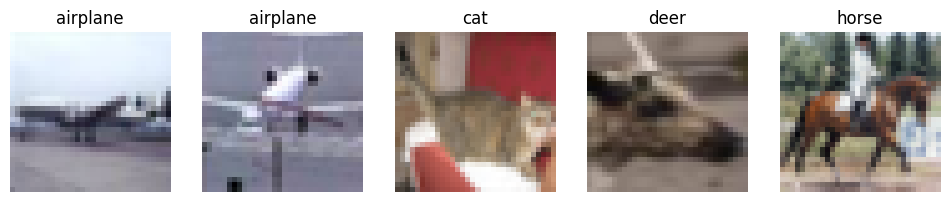

In [7]:
show_random_samples(dataset)


In [8]:
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True).to(device)
target_model.eval()



/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 23.2MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [9]:
test_accuracy = evaluate_accuracy(target_model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Test Accuracy: 92.60%


In [10]:
original_images, adversarial_images, labels = generate_adversarial_examples(target_model, test_loader, epsilon)
success_count = attack_success(target_model, adversarial_images, labels)
print(f"Attack Success Rate: {success_count/len(labels) * 100:.2f}%")




Attack Success Rate: 31.35%


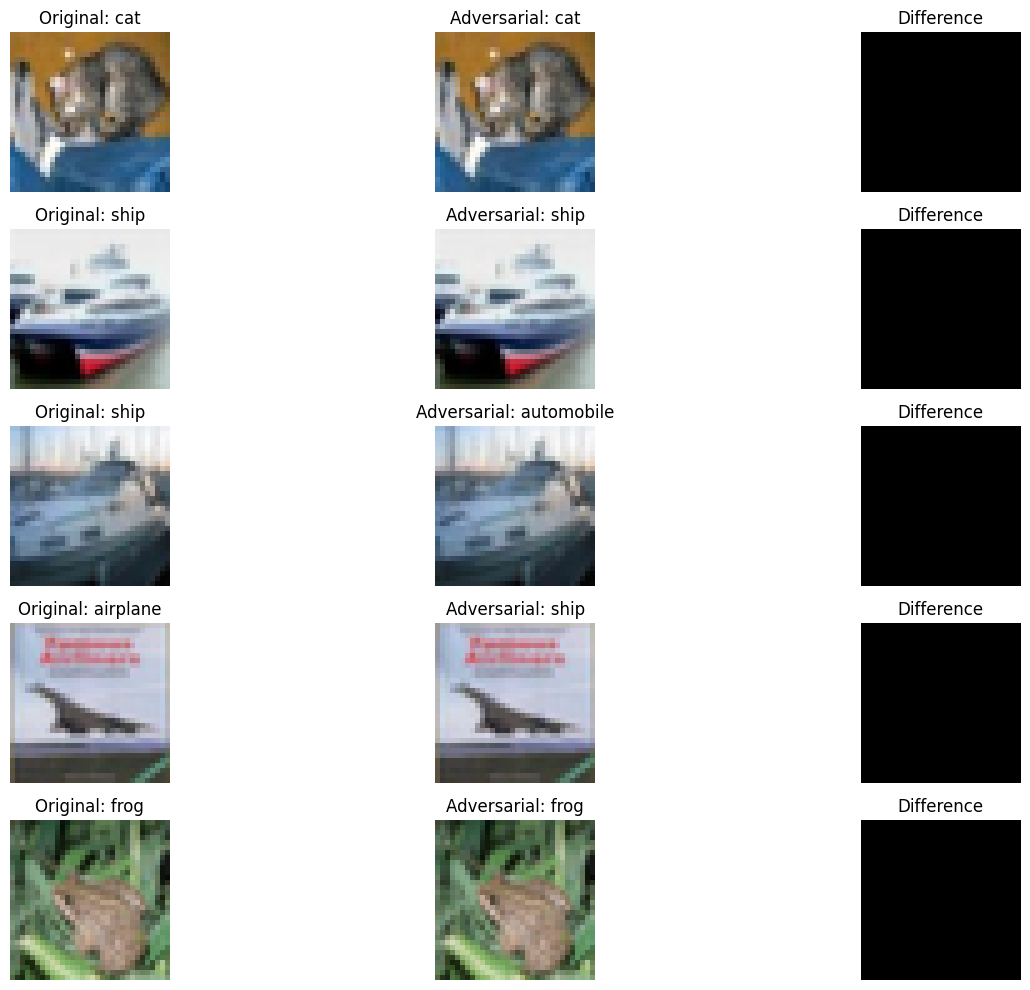

In [11]:
with torch.no_grad():
    predicted_labels = target_model(adversarial_images).argmax(dim=1)

plot_adversarial_images(original_images[:5], adversarial_images[:5], labels[:5], predicted_labels[:5], class_names=test_dataset.classes)

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1), nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)
        )

    def forward(self, x):
        return self.model(x)


In [13]:
def adv_target_model_loss(logits, labels, num_classes=10):
    labels = torch.eye(num_classes).type(logits.type())[labels.long()]
    real = torch.sum(labels * logits, 1)
    other = torch.max((1 - labels) * logits - (labels * 10000), 1)[0]
    return torch.sum(torch.max(real - other, torch.zeros_like(other).fill_(0)))

In [14]:
criterion_gan = nn.MSELoss()
criterion_adv = adv_target_model_loss
criterion_hinge = lambda perturb: torch.mean(torch.clamp(torch.norm(perturb.view(perturb.size(0), -1), dim=1) - c, min=0))

generator = Generator().to(device)
discriminator = Discriminator().to(device)

opt_gen = optim.Adam(generator.parameters(), lr=lr)
opt_disc = optim.Adam(discriminator.parameters(), lr=lr)



Training Epoch 1/50: 100%|██████████| 313/313 [00:33<00:00,  9.35it/s]


Epoch 1/50:
  Train Generator Loss: 130.2862, Discriminator Loss: 1.0856
  Val Generator Loss: 117.5492, Discriminator Loss: 1.1444
  Train Attack Success Rate: 0.7675
  Val Attack Success Rate: 0.7659
  Model saved!


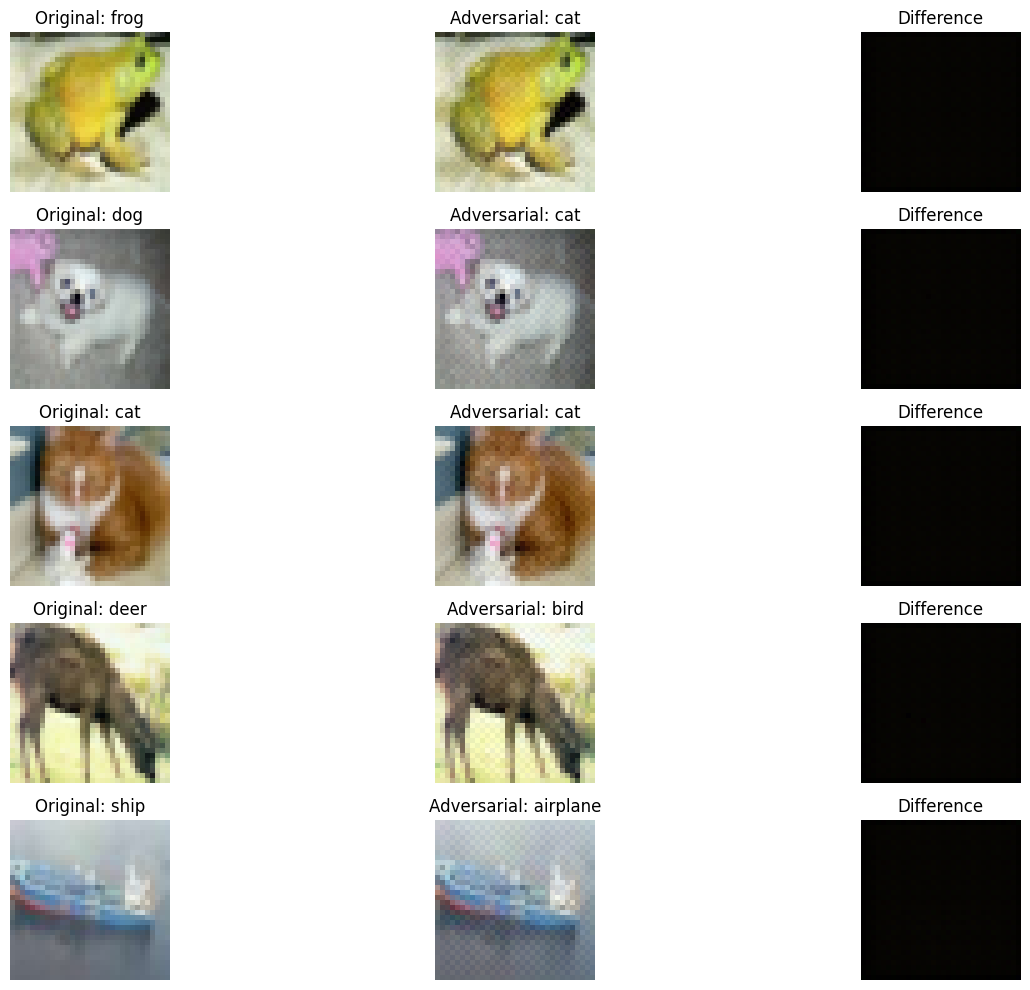

Training Epoch 2/50: 100%|██████████| 313/313 [00:32<00:00,  9.60it/s]


Epoch 2/50:
  Train Generator Loss: 127.5616, Discriminator Loss: 0.0943
  Val Generator Loss: 115.4352, Discriminator Loss: 0.8179
  Train Attack Success Rate: 0.7546
  Val Attack Success Rate: 0.7616
  Model saved!


Training Epoch 3/50: 100%|██████████| 313/313 [00:32<00:00,  9.60it/s]


Epoch 3/50:
  Train Generator Loss: 114.8409, Discriminator Loss: 0.0227
  Val Generator Loss: 99.5218, Discriminator Loss: 0.4651
  Train Attack Success Rate: 0.7791
  Val Attack Success Rate: 0.8376
  Model saved!


Training Epoch 4/50: 100%|██████████| 313/313 [00:32<00:00,  9.66it/s]


Epoch 4/50:
  Train Generator Loss: 97.2298, Discriminator Loss: 0.0061
  Val Generator Loss: 85.7229, Discriminator Loss: 0.5485
  Train Attack Success Rate: 0.8185
  Val Attack Success Rate: 0.8747
  Model saved!


Training Epoch 5/50: 100%|██████████| 313/313 [00:32<00:00,  9.56it/s]


Epoch 5/50:
  Train Generator Loss: 100.8537, Discriminator Loss: 0.0703
  Val Generator Loss: 88.5359, Discriminator Loss: 0.9903
  Train Attack Success Rate: 0.8206
  Val Attack Success Rate: 0.8058


Training Epoch 6/50: 100%|██████████| 313/313 [00:32<00:00,  9.53it/s]


Epoch 6/50:
  Train Generator Loss: 110.7782, Discriminator Loss: 0.0641
  Val Generator Loss: 104.4790, Discriminator Loss: 0.4770
  Train Attack Success Rate: 0.8016
  Val Attack Success Rate: 0.7587


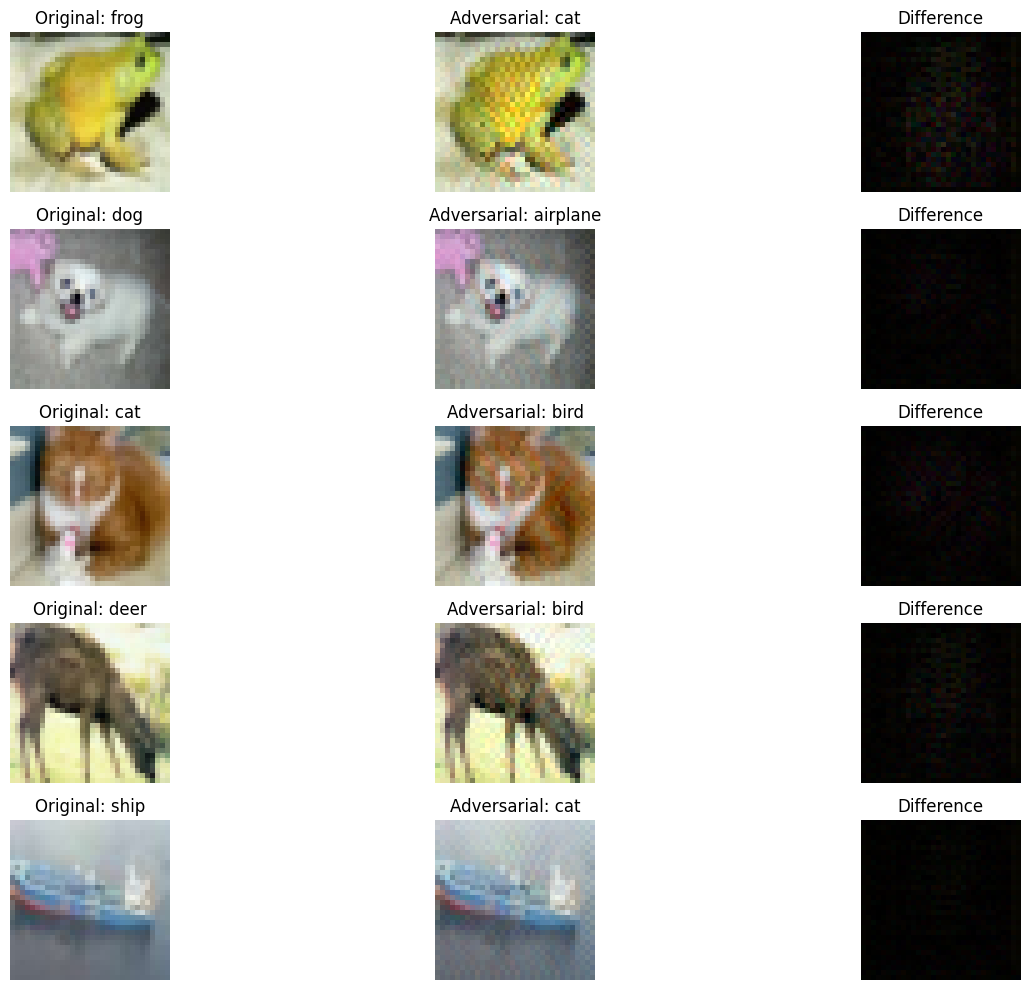

Training Epoch 7/50: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 7/50:
  Train Generator Loss: 113.0257, Discriminator Loss: 0.0508
  Val Generator Loss: 108.1968, Discriminator Loss: 0.4499
  Train Attack Success Rate: 0.7887
  Val Attack Success Rate: 0.8116


Training Epoch 8/50: 100%|██████████| 313/313 [00:32<00:00,  9.68it/s]


Epoch 8/50:
  Train Generator Loss: 117.7209, Discriminator Loss: 0.0377
  Val Generator Loss: 99.0130, Discriminator Loss: 0.5450
  Train Attack Success Rate: 0.7784
  Val Attack Success Rate: 0.8210


Training Epoch 9/50: 100%|██████████| 313/313 [00:32<00:00,  9.70it/s]


Epoch 9/50:
  Train Generator Loss: 108.3800, Discriminator Loss: 0.0301
  Val Generator Loss: 106.4554, Discriminator Loss: 0.3671
  Train Attack Success Rate: 0.8084
  Val Attack Success Rate: 0.8484


Training Epoch 10/50: 100%|██████████| 313/313 [00:32<00:00,  9.62it/s]


Epoch 10/50:
  Train Generator Loss: 102.8156, Discriminator Loss: 0.0173
  Val Generator Loss: 76.8417, Discriminator Loss: 0.4783
  Train Attack Success Rate: 0.8268
  Val Attack Success Rate: 0.8765
  Model saved!


Training Epoch 11/50: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 11/50:
  Train Generator Loss: 81.9593, Discriminator Loss: 0.0042
  Val Generator Loss: 72.0021, Discriminator Loss: 0.5886
  Train Attack Success Rate: 0.8696
  Val Attack Success Rate: 0.8686
  Model saved!


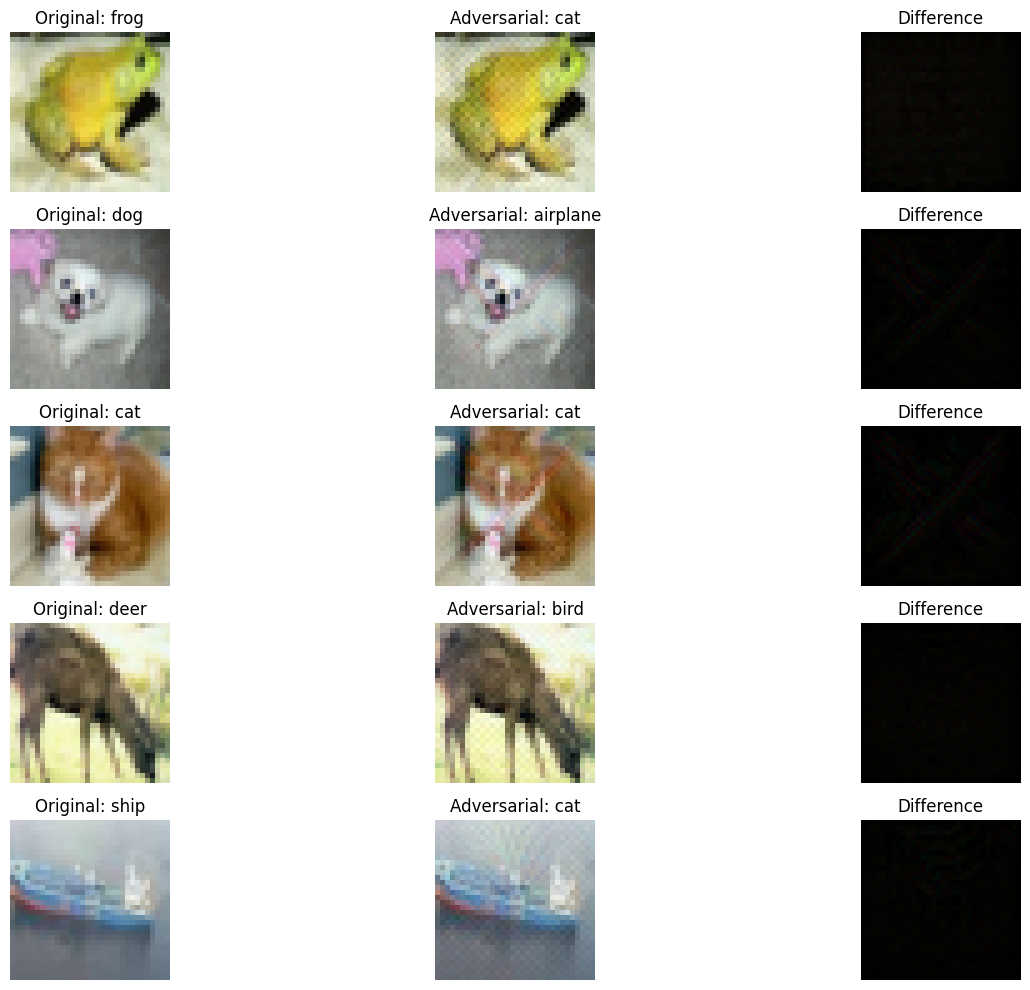

Training Epoch 12/50: 100%|██████████| 313/313 [00:32<00:00,  9.53it/s]


Epoch 12/50:
  Train Generator Loss: 77.5482, Discriminator Loss: 0.0032
  Val Generator Loss: 71.7418, Discriminator Loss: 0.5127
  Train Attack Success Rate: 0.8803
  Val Attack Success Rate: 0.8778
  Model saved!


Training Epoch 13/50: 100%|██████████| 313/313 [00:32<00:00,  9.64it/s]


Epoch 13/50:
  Train Generator Loss: 74.7346, Discriminator Loss: 0.0030
  Val Generator Loss: 69.2812, Discriminator Loss: 0.5455
  Train Attack Success Rate: 0.8850
  Val Attack Success Rate: 0.8598
  Model saved!


Training Epoch 14/50: 100%|██████████| 313/313 [00:32<00:00,  9.57it/s]


Epoch 14/50:
  Train Generator Loss: 72.4304, Discriminator Loss: 0.0020
  Val Generator Loss: 72.3556, Discriminator Loss: 0.5625
  Train Attack Success Rate: 0.8923
  Val Attack Success Rate: 0.8133


Training Epoch 15/50: 100%|██████████| 313/313 [00:32<00:00,  9.51it/s]


Epoch 15/50:
  Train Generator Loss: 70.5478, Discriminator Loss: 0.0026
  Val Generator Loss: 69.5227, Discriminator Loss: 0.5231
  Train Attack Success Rate: 0.8967
  Val Attack Success Rate: 0.9119


Training Epoch 16/50: 100%|██████████| 313/313 [00:32<00:00,  9.62it/s]


Epoch 16/50:
  Train Generator Loss: 68.9537, Discriminator Loss: 0.0020
  Val Generator Loss: 67.8608, Discriminator Loss: 0.6305
  Train Attack Success Rate: 0.8986
  Val Attack Success Rate: 0.8873
  Model saved!


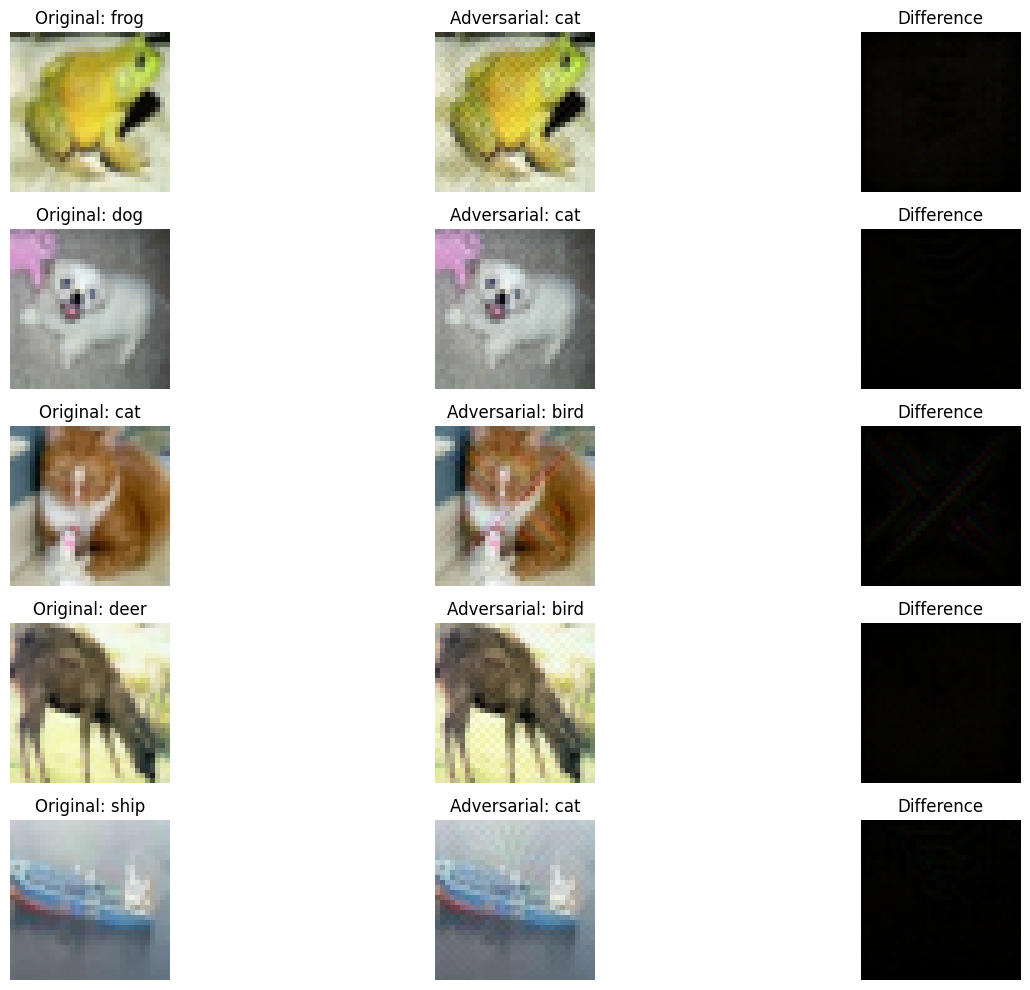

Training Epoch 17/50: 100%|██████████| 313/313 [00:32<00:00,  9.49it/s]


Epoch 17/50:
  Train Generator Loss: 67.5367, Discriminator Loss: 0.0017
  Val Generator Loss: 66.7557, Discriminator Loss: 0.5395
  Train Attack Success Rate: 0.9032
  Val Attack Success Rate: 0.8770
  Model saved!


Training Epoch 18/50: 100%|██████████| 313/313 [00:33<00:00,  9.48it/s]


Epoch 18/50:
  Train Generator Loss: 66.1419, Discriminator Loss: 0.0025
  Val Generator Loss: 68.3441, Discriminator Loss: 0.5758
  Train Attack Success Rate: 0.9044
  Val Attack Success Rate: 0.8241


Training Epoch 19/50: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 19/50:
  Train Generator Loss: 64.8790, Discriminator Loss: 0.0021
  Val Generator Loss: 68.8902, Discriminator Loss: 0.5384
  Train Attack Success Rate: 0.9087
  Val Attack Success Rate: 0.8280


Training Epoch 20/50: 100%|██████████| 313/313 [00:32<00:00,  9.57it/s]


Epoch 20/50:
  Train Generator Loss: 63.8150, Discriminator Loss: 0.0014
  Val Generator Loss: 67.4010, Discriminator Loss: 0.5395
  Train Attack Success Rate: 0.9098
  Val Attack Success Rate: 0.8428


Training Epoch 21/50: 100%|██████████| 313/313 [00:32<00:00,  9.55it/s]


Epoch 21/50:
  Train Generator Loss: 62.5506, Discriminator Loss: 0.0025
  Val Generator Loss: 70.9619, Discriminator Loss: 0.5614
  Train Attack Success Rate: 0.9142
  Val Attack Success Rate: 0.7929


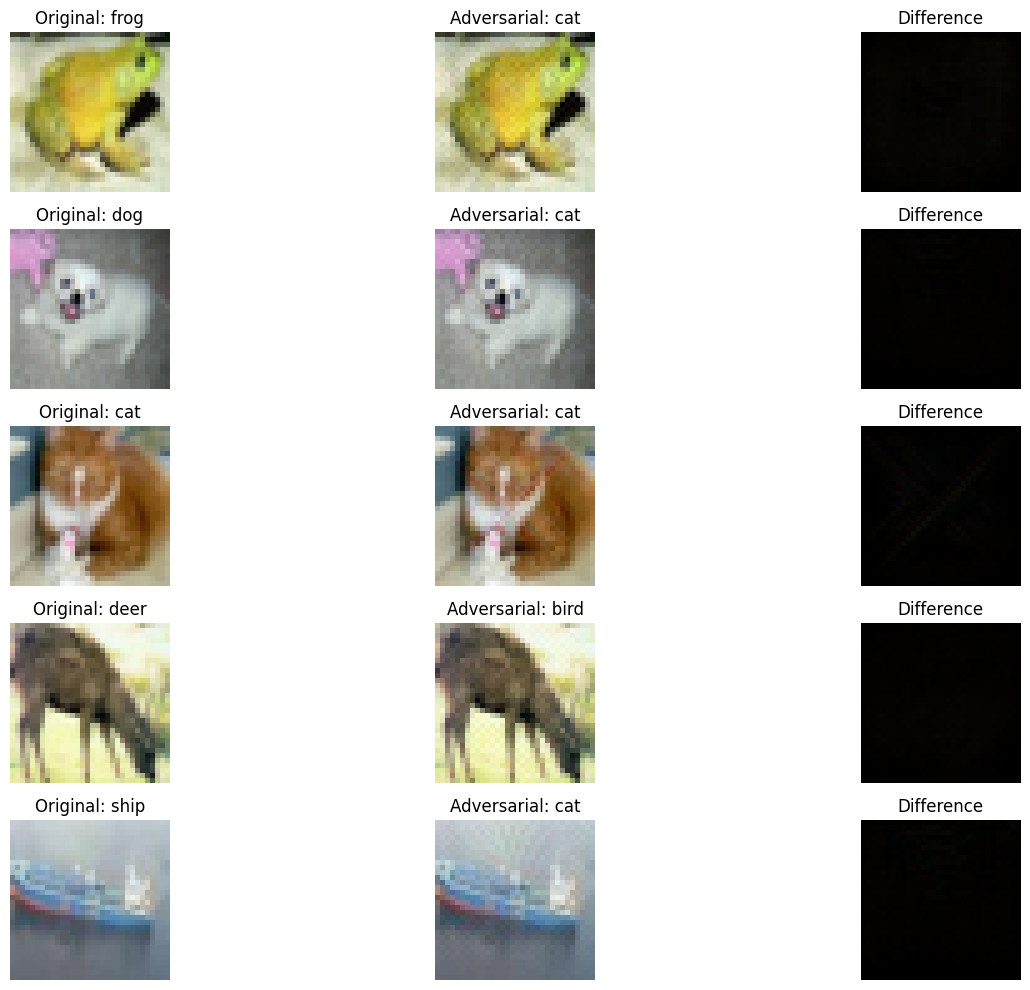

Training Epoch 22/50: 100%|██████████| 313/313 [00:32<00:00,  9.51it/s]


Epoch 22/50:
  Train Generator Loss: 61.7403, Discriminator Loss: 0.0013
  Val Generator Loss: 66.0143, Discriminator Loss: 0.5583
  Train Attack Success Rate: 0.9139
  Val Attack Success Rate: 0.8377
  Model saved!


Training Epoch 23/50: 100%|██████████| 313/313 [00:32<00:00,  9.60it/s]


Epoch 23/50:
  Train Generator Loss: 60.5587, Discriminator Loss: 0.0015
  Val Generator Loss: 66.9469, Discriminator Loss: 0.5592
  Train Attack Success Rate: 0.9172
  Val Attack Success Rate: 0.8417


Training Epoch 24/50: 100%|██████████| 313/313 [00:32<00:00,  9.58it/s]


Epoch 24/50:
  Train Generator Loss: 60.0304, Discriminator Loss: 0.0018
  Val Generator Loss: 70.5401, Discriminator Loss: 0.4981
  Train Attack Success Rate: 0.9194
  Val Attack Success Rate: 0.7940


Training Epoch 25/50: 100%|██████████| 313/313 [00:32<00:00,  9.64it/s]


Epoch 25/50:
  Train Generator Loss: 59.0794, Discriminator Loss: 0.0019
  Val Generator Loss: 70.2360, Discriminator Loss: 0.5544
  Train Attack Success Rate: 0.9199
  Val Attack Success Rate: 0.7977


Training Epoch 26/50: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 26/50:
  Train Generator Loss: 59.0500, Discriminator Loss: 0.0010
  Val Generator Loss: 70.4078, Discriminator Loss: 0.5299
  Train Attack Success Rate: 0.9204
  Val Attack Success Rate: 0.7715


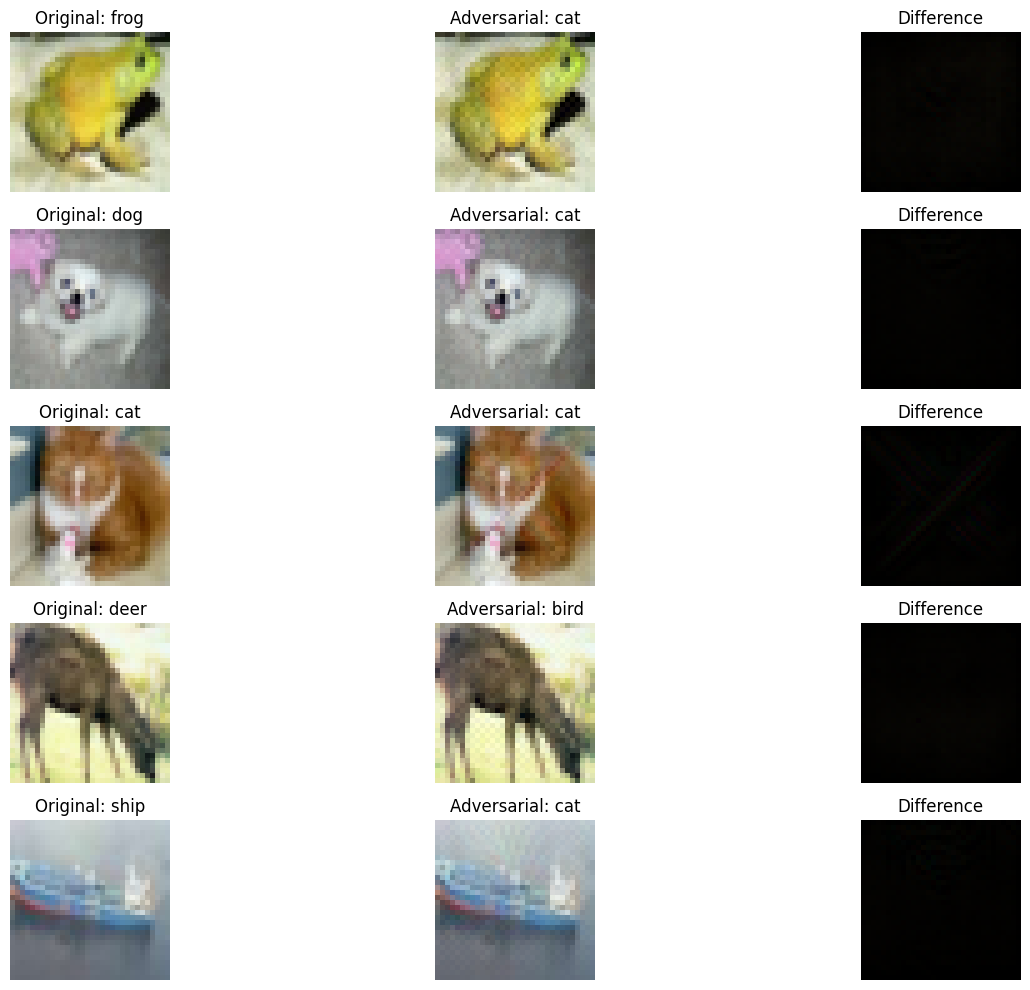

Training Epoch 27/50: 100%|██████████| 313/313 [00:32<00:00,  9.53it/s]


Epoch 27/50:
  Train Generator Loss: 57.7940, Discriminator Loss: 0.0016
  Val Generator Loss: 65.8050, Discriminator Loss: 0.5546
  Train Attack Success Rate: 0.9228
  Val Attack Success Rate: 0.8493
  Model saved!


Training Epoch 28/50: 100%|██████████| 313/313 [00:32<00:00,  9.51it/s]


Epoch 28/50:
  Train Generator Loss: 57.0585, Discriminator Loss: 0.0016
  Val Generator Loss: 64.8859, Discriminator Loss: 0.5684
  Train Attack Success Rate: 0.9247
  Val Attack Success Rate: 0.8473
  Model saved!


Training Epoch 29/50: 100%|██████████| 313/313 [00:32<00:00,  9.50it/s]


Epoch 29/50:
  Train Generator Loss: 56.1735, Discriminator Loss: 0.0010
  Val Generator Loss: 72.5405, Discriminator Loss: 0.5335
  Train Attack Success Rate: 0.9270
  Val Attack Success Rate: 0.7663


Training Epoch 30/50: 100%|██████████| 313/313 [00:33<00:00,  9.47it/s]


Epoch 30/50:
  Train Generator Loss: 55.9012, Discriminator Loss: 0.0008
  Val Generator Loss: 66.2759, Discriminator Loss: 0.5142
  Train Attack Success Rate: 0.9262
  Val Attack Success Rate: 0.8316


Training Epoch 31/50: 100%|██████████| 313/313 [00:33<00:00,  9.42it/s]


Epoch 31/50:
  Train Generator Loss: 55.1739, Discriminator Loss: 0.0006
  Val Generator Loss: 68.1269, Discriminator Loss: 0.5502
  Train Attack Success Rate: 0.9287
  Val Attack Success Rate: 0.8066


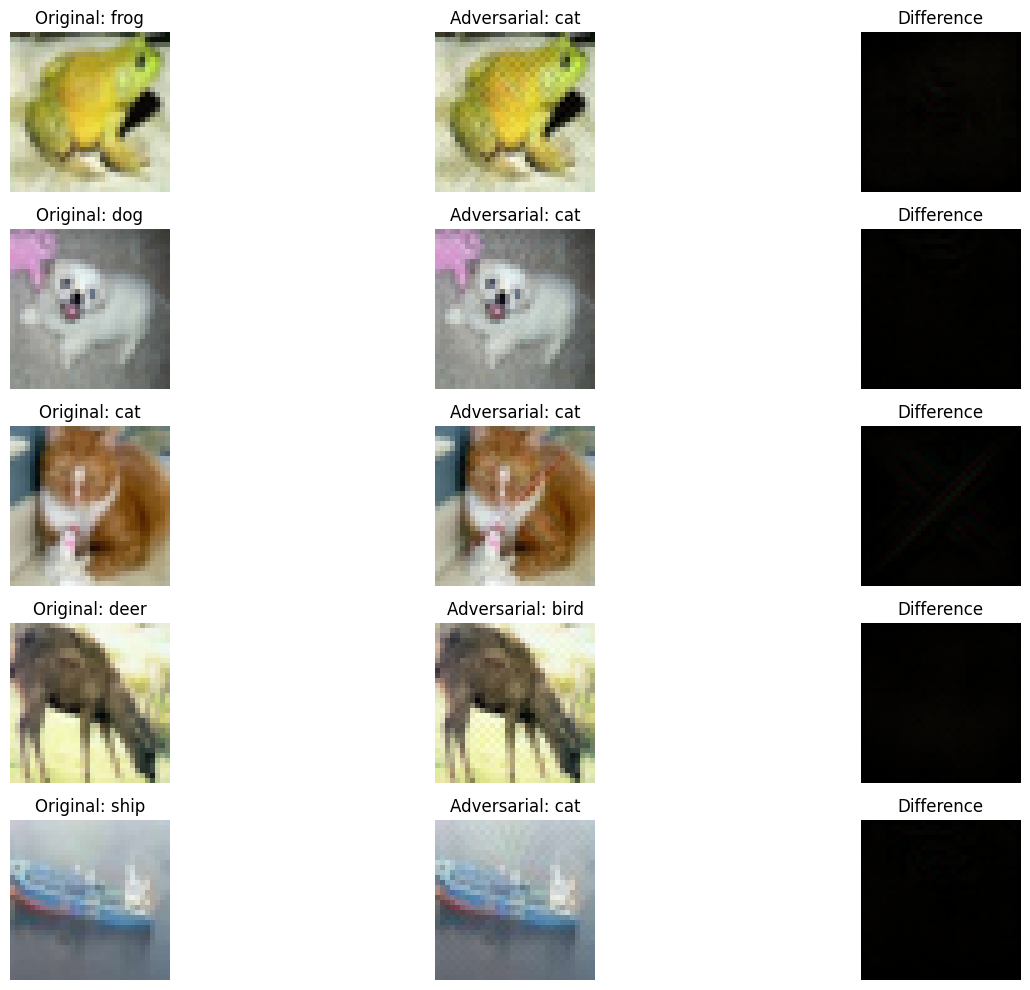

Training Epoch 32/50: 100%|██████████| 313/313 [00:33<00:00,  9.48it/s]


Epoch 32/50:
  Train Generator Loss: 54.4776, Discriminator Loss: 0.0005
  Val Generator Loss: 68.7519, Discriminator Loss: 0.5437
  Train Attack Success Rate: 0.9300
  Val Attack Success Rate: 0.8044


Training Epoch 33/50: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 33/50:
  Train Generator Loss: 54.0853, Discriminator Loss: 0.0006
  Val Generator Loss: 69.4857, Discriminator Loss: 0.5287
  Train Attack Success Rate: 0.9315
  Val Attack Success Rate: 0.7807


Training Epoch 34/50: 100%|██████████| 313/313 [00:32<00:00,  9.55it/s]


Epoch 34/50:
  Train Generator Loss: 53.4601, Discriminator Loss: 0.0005
  Val Generator Loss: 69.5989, Discriminator Loss: 0.5442
  Train Attack Success Rate: 0.9335
  Val Attack Success Rate: 0.7779


Training Epoch 35/50: 100%|██████████| 313/313 [00:32<00:00,  9.59it/s]


Epoch 35/50:
  Train Generator Loss: 53.3319, Discriminator Loss: 0.0005
  Val Generator Loss: 66.0850, Discriminator Loss: 0.5072
  Train Attack Success Rate: 0.9326
  Val Attack Success Rate: 0.8459


Training Epoch 36/50: 100%|██████████| 313/313 [00:32<00:00,  9.55it/s]


Epoch 36/50:
  Train Generator Loss: 52.7785, Discriminator Loss: 0.0006
  Val Generator Loss: 70.8561, Discriminator Loss: 0.5667
  Train Attack Success Rate: 0.9354
  Val Attack Success Rate: 0.7894


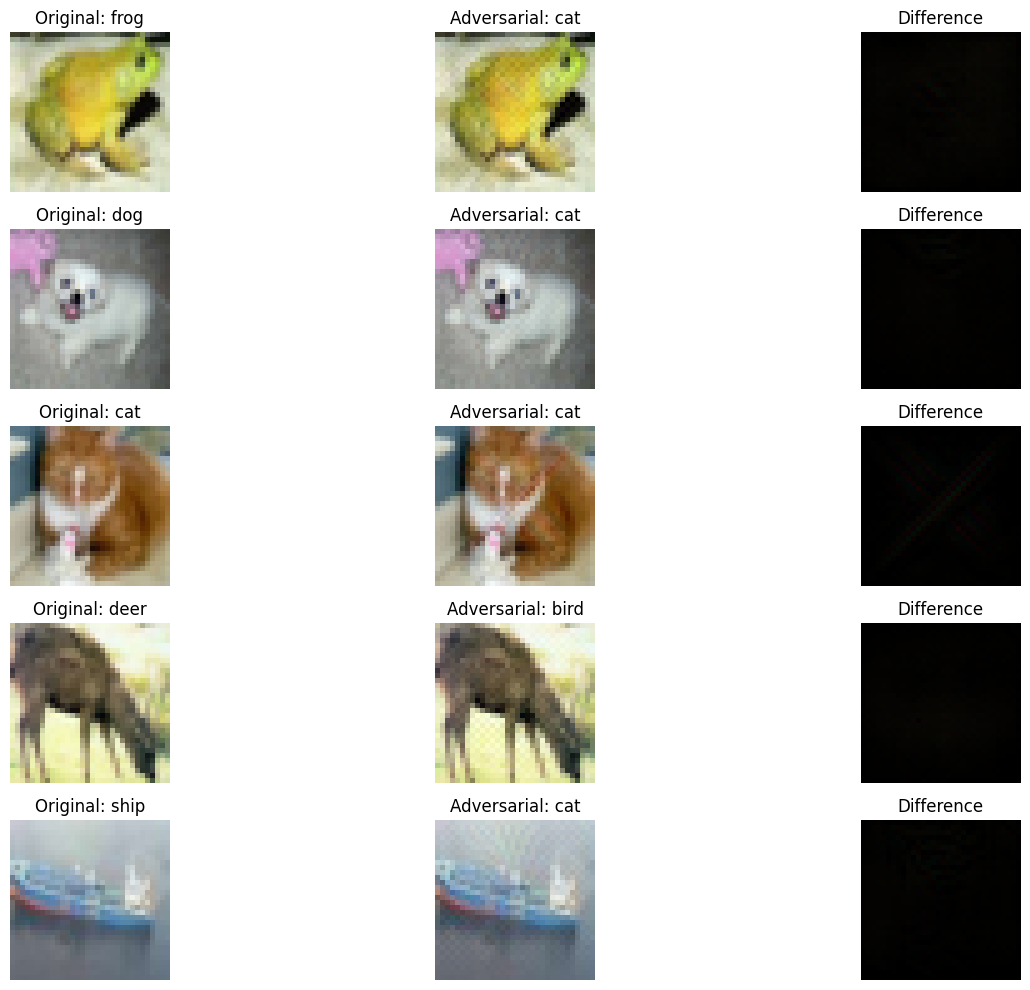

Training Epoch 37/50: 100%|██████████| 313/313 [00:32<00:00,  9.54it/s]


Epoch 37/50:
  Train Generator Loss: 52.4516, Discriminator Loss: 0.0004
  Val Generator Loss: 71.6200, Discriminator Loss: 0.5231
  Train Attack Success Rate: 0.9348
  Val Attack Success Rate: 0.7808


Training Epoch 38/50: 100%|██████████| 313/313 [00:32<00:00,  9.51it/s]


Epoch 38/50:
  Train Generator Loss: 56.1798, Discriminator Loss: 0.0618
  Val Generator Loss: 87.0984, Discriminator Loss: 0.3059
  Train Attack Success Rate: 0.9231
  Val Attack Success Rate: 0.7921


Training Epoch 39/50: 100%|██████████| 313/313 [00:32<00:00,  9.57it/s]


Epoch 39/50:
  Train Generator Loss: 75.0422, Discriminator Loss: 0.0570
  Val Generator Loss: 70.7482, Discriminator Loss: 0.5758
  Train Attack Success Rate: 0.8818
  Val Attack Success Rate: 0.8119


Training Epoch 40/50: 100%|██████████| 313/313 [00:32<00:00,  9.56it/s]


Epoch 40/50:
  Train Generator Loss: 58.1685, Discriminator Loss: 0.0030
  Val Generator Loss: 68.6844, Discriminator Loss: 0.5653
  Train Attack Success Rate: 0.9121
  Val Attack Success Rate: 0.8215


Training Epoch 41/50: 100%|██████████| 313/313 [00:32<00:00,  9.49it/s]


Epoch 41/50:
  Train Generator Loss: 55.2521, Discriminator Loss: 0.0012
  Val Generator Loss: 69.8365, Discriminator Loss: 0.5093
  Train Attack Success Rate: 0.9208
  Val Attack Success Rate: 0.7980


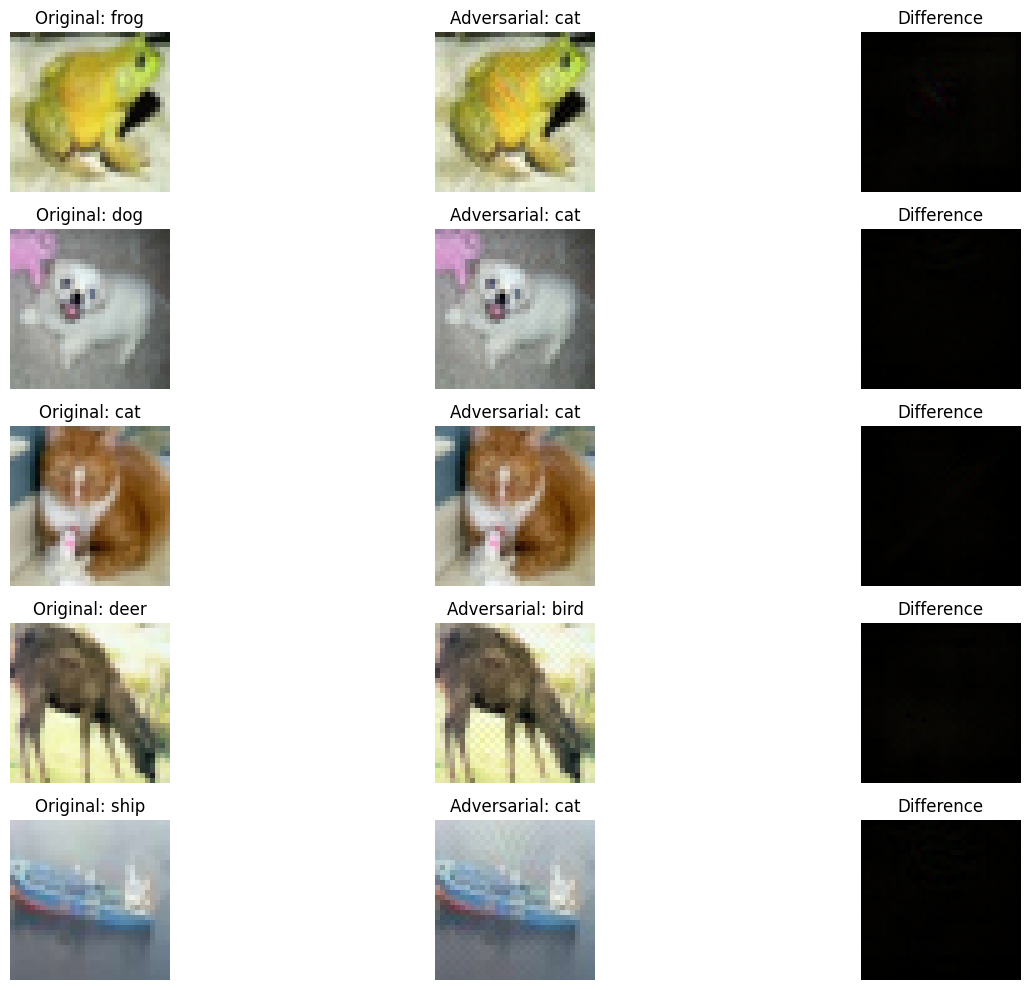

Training Epoch 42/50: 100%|██████████| 313/313 [00:33<00:00,  9.44it/s]


Epoch 42/50:
  Train Generator Loss: 53.3096, Discriminator Loss: 0.0008
  Val Generator Loss: 71.0923, Discriminator Loss: 0.5610
  Train Attack Success Rate: 0.9269
  Val Attack Success Rate: 0.7755


Training Epoch 43/50: 100%|██████████| 313/313 [00:33<00:00,  9.46it/s]


Epoch 43/50:
  Train Generator Loss: 52.6325, Discriminator Loss: 0.0009
  Val Generator Loss: 71.0602, Discriminator Loss: 0.6283
  Train Attack Success Rate: 0.9284
  Val Attack Success Rate: 0.7700
Early stopping triggered.


In [15]:
best_val_loss = float('inf')
patience_counter = 0

train_gen_losses = []
train_disc_losses = []
train_attack_success_rates = []

val_gen_losses = []
val_disc_losses = []
val_attack_success_rates = []

train_disc_accuracies = []
val_disc_accuracies = []

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    train_gen_loss = 0
    train_disc_loss = 0
    train_attack_success_counts = 0
    train_correct_disc = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)

        perturbations = generator(images)
        adversarial_images = images + perturbations

        opt_disc.zero_grad()
        real_loss = criterion_gan(discriminator(images), torch.ones((batch_size, 1), device=device))
        fake_loss = criterion_gan(discriminator(adversarial_images.detach()), torch.zeros((batch_size, 1), device=device))
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        opt_disc.step()

        opt_gen.zero_grad()
        adv_loss_value = criterion_adv(target_model(adversarial_images), labels)/4
        gan_loss = criterion_gan(discriminator(adversarial_images), torch.ones((batch_size, 1), device=device))
        hinge_loss = criterion_hinge(perturbations)
        gen_loss = alpha * gan_loss + beta * hinge_loss + adv_loss_value
        gen_loss.backward()
        opt_gen.step()

        train_gen_loss += gen_loss.item()
        train_disc_loss += disc_loss.item()
        train_attack_success_counts += attack_success(target_model, adversarial_images, labels)

        real_preds = discriminator(images) > 0.5
        fake_preds = discriminator(adversarial_images) < 0.5
        train_correct_disc += (real_preds.sum() + fake_preds.sum()).item()

    train_gen_loss /= len(train_loader)
    train_disc_loss /= len(train_loader)
    train_attack_success_rate = train_attack_success_counts / len(train_dataset)
    train_disc_accuracy = train_correct_disc / (len(train_dataset) * 2)

    train_gen_losses.append(train_gen_loss)
    train_disc_losses.append(train_disc_loss)
    train_attack_success_rates.append(train_attack_success_rate)
    train_disc_accuracies.append(train_disc_accuracy)
    

    generator.eval()
    discriminator.eval()

    val_gen_loss = 0
    val_disc_loss = 0
    val_attack_success_counts = 0
    val_correct_disc = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            batch_size = val_images.size(0)

            val_perturbations = generator(val_images)
            val_adversarial_images = val_images + val_perturbations

            val_adv_loss_value = criterion_adv(target_model(val_adversarial_images), val_labels)/4
            val_gan_loss = criterion_gan(discriminator(val_adversarial_images), torch.ones((batch_size, 1), device=device))
            val_hinge_loss = criterion_hinge(val_perturbations)
            val_gen_loss_batch = alpha * val_gan_loss + beta * val_hinge_loss + val_adv_loss_value

            val_real_loss = criterion_gan(discriminator(val_images), torch.ones((batch_size, 1), device=device))
            val_fake_loss = criterion_gan(discriminator(val_adversarial_images), torch.zeros((batch_size, 1), device=device))
            val_disc_loss_batch = val_real_loss + val_fake_loss

            val_gen_loss += val_gen_loss_batch.item()
            val_disc_loss += val_disc_loss_batch.item()
            val_attack_success_counts += attack_success(target_model, val_adversarial_images, val_labels)
            
            real_preds = discriminator(val_images) > 0.5
            fake_preds = discriminator(val_adversarial_images) < 0.5
            val_correct_disc += (real_preds.sum() + fake_preds.sum()).item()

    val_gen_loss /= len(val_loader)
    val_disc_loss /= len(val_loader)
    val_attack_success_rate = val_attack_success_counts / len(val_dataset)
    val_disc_accuracy = val_correct_disc / (len(val_dataset)* 2)

    val_gen_losses.append(val_gen_loss)
    val_disc_losses.append(val_disc_loss)
    val_attack_success_rates.append(val_attack_success_rate)
    val_disc_accuracies.append(val_disc_accuracy)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Generator Loss: {train_gen_loss:.4f}, Discriminator Loss: {train_disc_loss:.4f}")
    print(f"  Val Generator Loss: {val_gen_loss:.4f}, Discriminator Loss: {val_disc_loss:.4f}")
    print(f"  Train Attack Success Rate: {train_attack_success_rate:.4f}")
    print(f"  Val Attack Success Rate: {val_attack_success_rate:.4f}")

    if val_gen_loss < best_val_loss:
        best_val_loss = val_gen_loss
        patience_counter = 0
        torch.save(generator.state_dict(), 'best_generator.pth')
        torch.save(discriminator.state_dict(), 'best_discriminator.pth')
        print("  Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    if epoch % 5 == 0:
        with torch.no_grad():
            images, labels = next(iter(val_loader))
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            fake_images = images + perturbations
            logits = target_model(fake_images)
            plot_adversarial_images(images[:5], fake_images[:5], labels[:5], logits[:5].argmax(dim=1), class_names=test_dataset.classes)


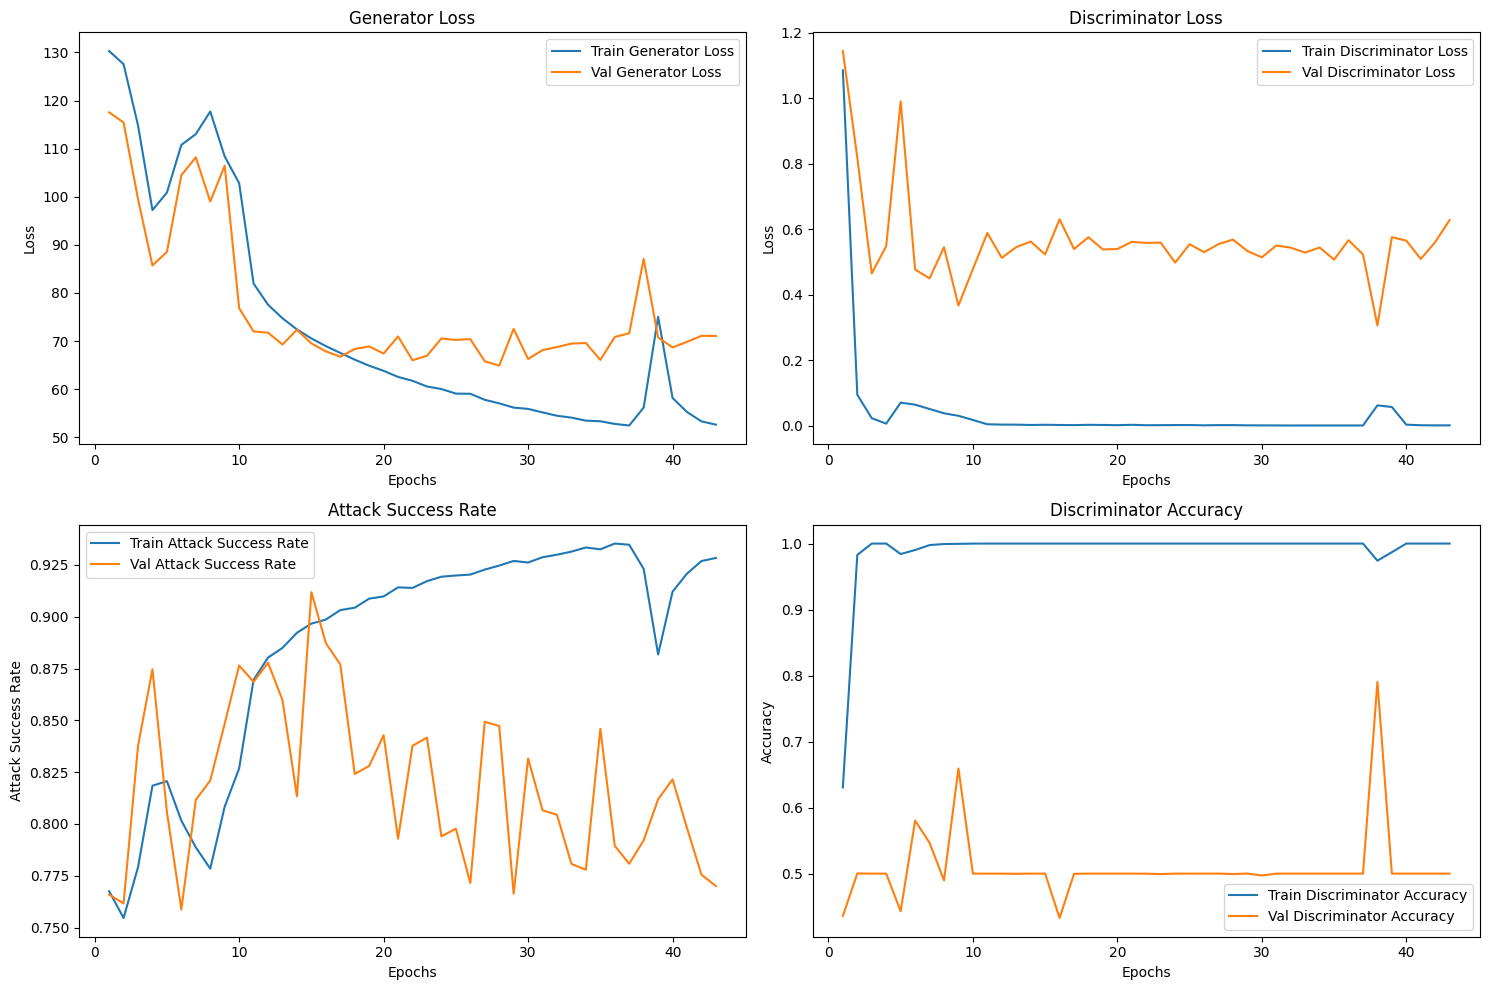

In [16]:
import matplotlib.pyplot as plt

def plot_training_metrics(train_gen_losses, train_disc_losses, train_attack_success_rates, train_disc_accuracies,
                          val_gen_losses, val_disc_losses, val_attack_success_rates, val_disc_accuracies):
    epochs = range(1, len(train_gen_losses) + 1)

    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_gen_losses, label="Train Generator Loss")
    plt.plot(epochs, val_gen_losses, label="Val Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Generator Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_disc_losses, label="Train Discriminator Loss")
    plt.plot(epochs, val_disc_losses, label="Val Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss")
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_attack_success_rates, label="Train Attack Success Rate")
    plt.plot(epochs, val_attack_success_rates, label="Val Attack Success Rate")
    plt.xlabel("Epochs")
    plt.ylabel("Attack Success Rate")
    plt.title("Attack Success Rate")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_disc_accuracies, label="Train Discriminator Accuracy")
    plt.plot(epochs, val_disc_accuracies, label="Val Discriminator Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Discriminator Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_training_metrics(
    train_gen_losses=train_gen_losses,
    train_disc_losses=train_disc_losses,
    train_attack_success_rates=train_attack_success_rates,
    train_disc_accuracies=train_disc_accuracies,
    val_gen_losses=val_gen_losses,
    val_disc_losses=val_disc_losses,
    val_attack_success_rates=val_attack_success_rates,
    val_disc_accuracies=val_disc_accuracies
)



In [17]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.load_state_dict(torch.load('best_generator.pth'))
discriminator.load_state_dict(torch.load('best_discriminator.pth'))

<ipython-input-17-c82e7d57fe51>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('best_generator.pth'))
<ipython-input-17-c82e7d57fe51>:

<All keys matched successfully>

Evaluating on Test Data: 100%|██████████████████████████████████████| 79/79 [00:03<00:00, 20.62it/s]


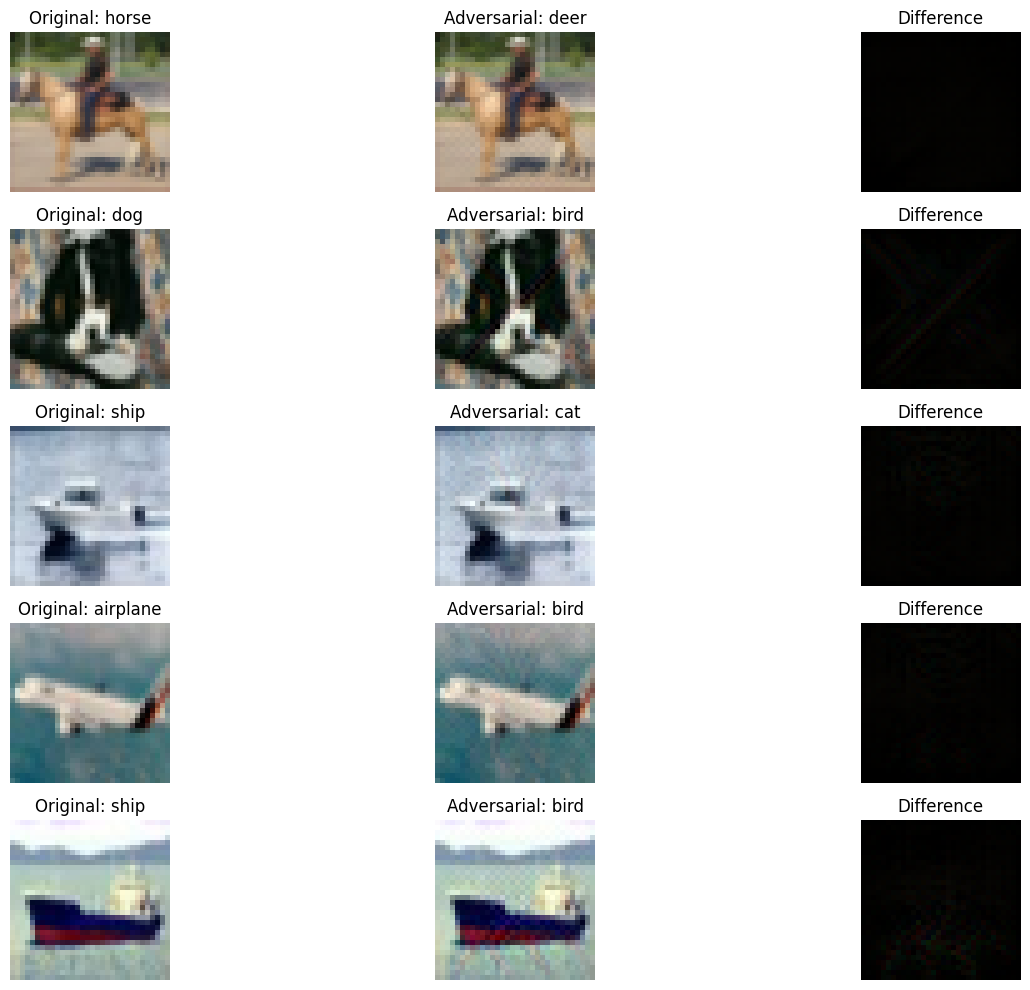

Test Attack Success Rate: 84.75%


In [18]:
test_attack_success_counts = 0

generator.eval()
discriminator.eval()
target_model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Data", ncols=100):
        images, labels = images.to(device), labels.to(device)

        perturbations = generator(images)
        fake_images = images + perturbations
        
        test_attack_success_counts += attack_success(target_model, fake_images, labels)
        logits = target_model(fake_images)
    plot_adversarial_images(images[:5], fake_images[:5], labels[:5], logits[:5].argmax(dim=1), class_names=test_dataset.classes)
        
test_attack_success_rate = test_attack_success_counts / len(test_dataset)

print(f"Test Attack Success Rate: {test_attack_success_rate * 100:.2f}%")


In [19]:
def calculate_attack_success_rate_per_class(model, generator, dataloader, device, num_classes):
    model.eval()
    generator.eval()
    class_success = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            perturbations = generator(images)
            adversarial_images = images + perturbations

            adv_preds = model(adversarial_images).argmax(dim=1)

            for i in range(labels.size(0)):
                label = labels[i].item()
                class_total[label] += 1
                if labels[i] != adv_preds[i]:
                    class_success[label] += 1

    attack_success_rate_per_class = [class_success[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return attack_success_rate_per_class

num_classes = 10 
attack_success_rate_per_class = calculate_attack_success_rate_per_class(target_model, generator, test_loader, device, num_classes)
for i, rate in enumerate(attack_success_rate_per_class):
    print(f"Attack Success Rate for Class {i}: {rate * 100:.2f}%")

Attack Success Rate for Class 0: 81.10%
Attack Success Rate for Class 1: 81.20%
Attack Success Rate for Class 2: 68.00%
Attack Success Rate for Class 3: 62.10%
Attack Success Rate for Class 4: 93.00%
Attack Success Rate for Class 5: 96.80%
Attack Success Rate for Class 6: 90.60%
Attack Success Rate for Class 7: 92.10%
Attack Success Rate for Class 8: 91.70%
Attack Success Rate for Class 9: 90.90%


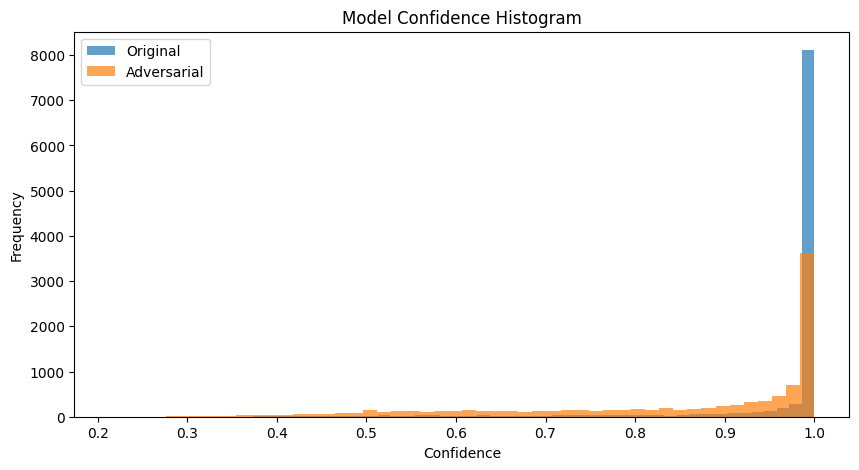

In [20]:
with torch.no_grad():
    original_confidences = []
    adversarial_confidences = []
    for images, _ in test_loader:
        images = images.to(device)
        perturbations = generator(images)
        adv_images = torch.clamp(images + perturbations, -1, 1)

        original_probs = torch.softmax(target_model(images), dim=1)
        adv_probs = torch.softmax(target_model(adv_images), dim=1)

        original_confidences.extend(original_probs.max(dim=1).values.cpu().numpy())
        adversarial_confidences.extend(adv_probs.max(dim=1).values.cpu().numpy())

plt.figure(figsize=(10, 5))
plt.hist(original_confidences, bins=50, alpha=0.7, label="Original")
plt.hist(adversarial_confidences, bins=50, alpha=0.7, label="Adversarial")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Model Confidence Histogram")
plt.legend()
plt.show()